# **Reconnaissance faciale à l'aide des modèles d'apprentissage profond VGG-16 et VGG-19**
L'objectif de ce projet est de développer un système de reconnaissance faciale basé sur le modèle d'apprentissage profond VGG (Visual Geometry Group).

La reconnaissance faciale joue un rôle crucial dans de nombreux domaines, tels que la sécurité, la surveillance et l'authentification. Notre approche utilise le puissant modèle VGG pour extraire des caractéristiques faciales significatives à partir d'images.


Ces caractéristiques sont employées pour former un algorithme de classification qui permet de confirmer l'identité des individus. Le système que nous avons mis en place se distingue par sa précision remarquable et sa résistance aux variations de lumière, d'expression faciale et de position.

Et pour terminer nous avons développé une application web conviviale qui permet aux utilisateurs de télécharger une image et d'obtenir la prédiction de classe correspondante à l'aide du modèle VGG19 et VGG16.

In [1]:
%%capture
# Montage de mon Google Drive
from google.colab import drive
drive.mount('/content/drive')

## Importation de la datatset et création du model VGG19

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Model
import numpy as np

# Définir la taille de l'image et le nombre de classes
taille_image = (224, 224)
# Trois classes c'est à dire 11 célébrités dans l'ensemble de données
nombre_classes = 11

# Charger le modèle VGG19 pré-entraîné sans les couches supérieures (entièrement connectées)
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(taille_image[0], taille_image[1], 3))

# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches au modèle
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(nombre_classes, activation='softmax')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=output)

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Définir les chemins d'accès aux ensembles d'entraînement et de test du jeu de données des célébrités
chemin_entrainement = '/content/drive/MyDrive/dataset/Team_Maroc/train'
chemin_test = '/content/drive/MyDrive/dataset/Team_Maroc/test'

# Configurer les générateurs de données pour l'entraînement et les tests
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    chemin_entrainement, target_size=taille_image, batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    chemin_test, target_size=taille_image, batch_size=32, class_mode='categorical')

80134624/80134624 [==============================] - 0s 0us/step
Found 960 images belonging to 11 classes.
Found 283 images belonging to 11 classes.


In [3]:
import time

# Start the timer
start_time = time.time()

# Train the model
vgg19 = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=20, validation_data=test_generator)

# Stop the timer
end_time = time.time()

# Calculate the time it took to train the model
training_time = end_time - start_time
training_time_minutes = round(training_time / 60, 2)
print(f"Temps d'entraînement : {training_time_minutes} minutes")

Epoch 1/20
30/30 [==============================] - 446s 15s/step - loss: 4.3925 - accuracy: 0.1344 - val_loss: 2.1320 - val_accuracy: 0.3004
Epoch 2/20
30/30 [==============================] - 17s 557ms/step - loss: 1.8715 - accuracy: 0.3729 - val_loss: 1.4967 - val_accuracy: 0.5477
Epoch 3/20
30/30 [==============================] - 17s 576ms/step - loss: 1.5332 - accuracy: 0.5104 - val_loss: 1.3237 - val_accuracy: 0.5972
Epoch 4/20
30/30 [==============================] - 17s 576ms/step - loss: 1.3503 - accuracy: 0.5969 - val_loss: 1.0625 - val_accuracy: 0.6749
Epoch 5/20
30/30 [==============================] - 17s 580ms/step - loss: 1.0853 - accuracy: 0.7073 - val_loss: 0.8854 - val_accuracy: 0.7739
Epoch 6/20
30/30 [==============================] - 17s 567ms/step - loss: 0.9362 - accuracy: 0.7344 - val_loss: 0.7048 - val_accuracy: 0.8587
Epoch 7/20
30/30 [==============================] - 18s 608ms/step - loss: 0.8461 - accuracy: 0.7656 - val_loss: 0.6486 - val_accuracy: 0.8269


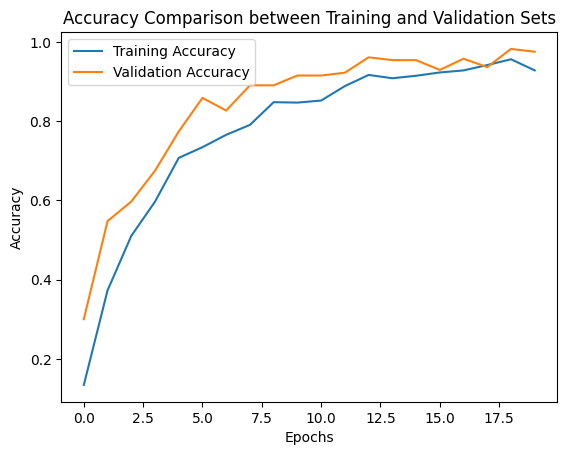

In [4]:
import matplotlib.pyplot as plt

# Traçage de la courbe de perte entre l'entraînement et la validation

plt.plot(vgg19.history['accuracy'])
plt.plot(vgg19.history['val_accuracy'])
plt.title("Accuracy Comparison between Training and Validation Sets")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [5]:
# Sauvegarder le modèle pour une utilisation ultérieure
model.save('/content/drive/MyDrive/model/VGG19_TeamMaroc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 2s 161ms/step


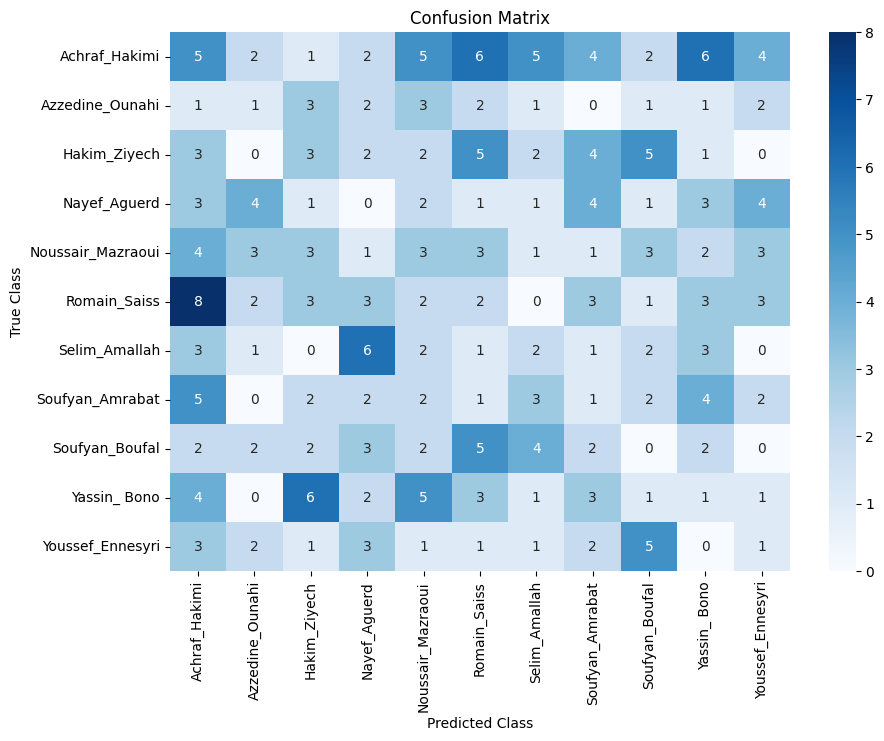

1/1 [==============================] - 0s 262ms/step


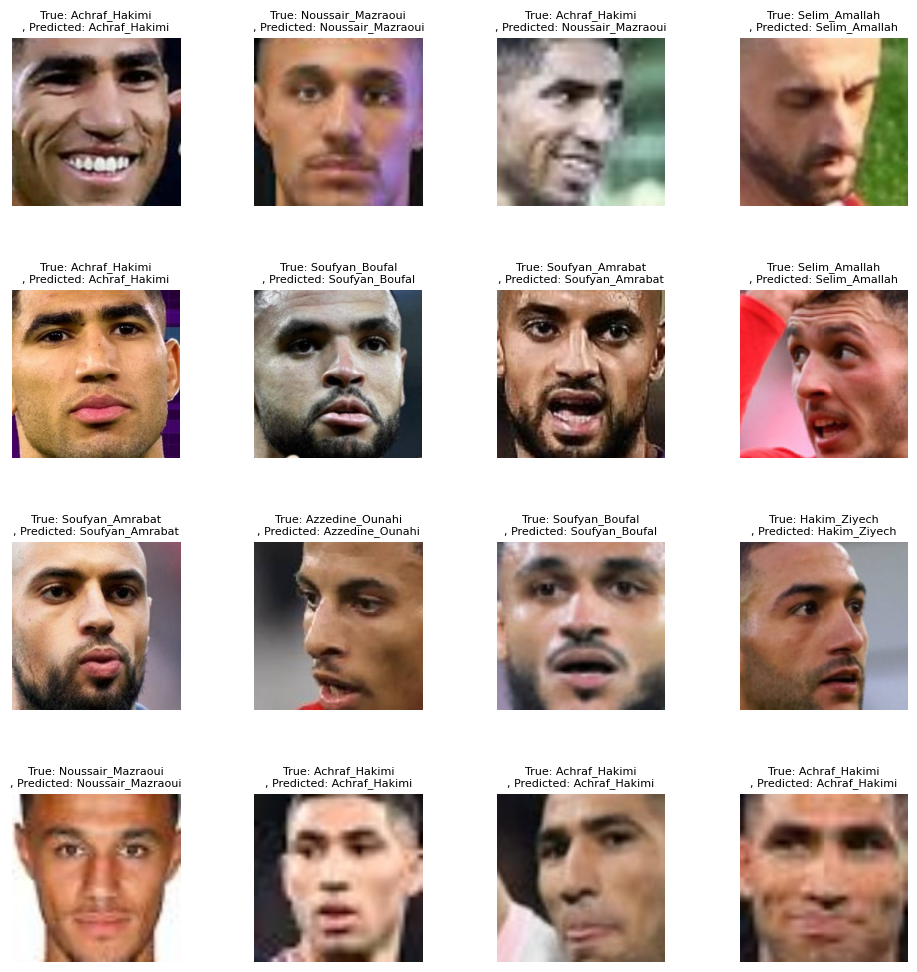

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Prédire les classes pour l'ensemble de test
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = test_generator.classes

# Créer la matrice de confusion
cm = confusion_matrix(true_classes, y_pred_classes)

# Afficher la matrice de confusion sous forme de graphique
class_labels = list(test_generator.class_indices.keys())  #  Obtenir les étiquettes de classe réelles
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Afficher quelques images de test avec leurs étiquettes prédites et réelles
sample_images, sample_labels = next(test_generator)

predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i in range(len(axes)):
    true_label = class_labels[np.argmax(sample_labels[i])]
    predicted_label = class_labels[predicted_classes[i]]
    axes[i].imshow(sample_images[i])
    axes[i].set_title(f"True: {true_label}\n, Predicted: {predicted_label}", fontsize=8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np


def predict_image_class(image_path, model, class_labels):
    # Charger l'image et la redimensionner à la taille requise pour le modèle
    image_size = (224, 224)
    image = load_img(image_path, target_size=image_size)
    image_array = np.expand_dims(img_to_array(image) / 255, axis=0)

    # Utiliser le modèle pour prédire la classe de l'image
    predictions = model.predict(image_array)
    predicted_class_index = np.argmax(predictions[0])

    # Obtenir la classe prédite
    predicted_class = class_labels[predicted_class_index]

    # Retourner la classe prédite
    return predicted_class


# Définir les étiquettes de classe
class_labels = ['Achraf Hakimi', 'Azzedine Ounahi', 'Hakim Ziyech', 'Nayef Aguerd', 'Noussair Mazraoui',
                'Romain Saiss', 'Selim Amallah', 'Soufyan Amrabat', 'Soufyan Boufal', 'Yassin Bono',
                'Youssef Ennesyri']

#model = tf.keras.models.load_model('/content/drive/MyDrive/model/VGG19_Celeb.keras')


# Définir le chemin d'accès à l'image à prédire
image_path = '/content/drive/MyDrive/dataset/Team_Maroc/test/Achraf_Hakimi/100.jpg'

# Prédire la classe de l'image
predicted_class = predict_image_class(image_path, model, class_labels)

# Afficher la classe prédite
print('Prediction:', predicted_class)

1/1 [==============================] - 1s 1s/step
Prediction: Achraf Hakimi


In [8]:
# Refaire la prédiction avec une autre image
image_path = '/content/drive/MyDrive/dataset/Team_Maroc/test/Hakim_Ziyech/76.jpg'
predicted_class = predict_image_class(image_path, model, class_labels)
print('Prediction:', predicted_class)

1/1 [==============================] - 0s 31ms/step
Prediction: Hakim Ziyech


In [10]:
# Charger le modèle depuis le disque puis prédire la classe de l'image
#model = tf.keras.models.load_model('/content/VGG19_TeamMaroc.h5')
image_path = '/content/drive/MyDrive/dataset/Team_Maroc/test/Hakim_Ziyech/76.jpg'
predicted_class = predict_image_class(image_path, model, class_labels)
print('Prediction:', predicted_class)


1/1 [==============================] - 0s 30ms/step
Prediction: Hakim Ziyech


# Creation du modéle VGG16
Cette deuxiéme partie est consacrée à la création du modéle VGG16, puis nous allons refaire le méme procédé que nous avons fait avec le modéle VGG19.
Et cela pour pouvoir comparer les deux modéles et voir lequel est le plus performant.

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Model
import numpy as np

# Redimensionner les images à 224 x 224 pixels
image_size = (224, 224)
num_classes = 11

# Chargement du modèle VGG16 pré-entraîné sans les couches supérieures (entièrement connectées)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(image_size[0], image_size[1], 3))

# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches au modèle
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=output)

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Définir les chemins d'accès aux ensembles d'entraînement et de test du jeu de données des célébrités
train_path = '/content/drive/MyDrive/dataset/Team_Maroc/train'
test_path = '/content/drive/MyDrive/dataset/Team_Maroc/test'

# Configurer les générateurs de données pour l'entraînement et les tests
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path, target_size=image_size, batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_path, target_size=image_size, batch_size=32, class_mode='categorical')

start_time = time.time()
# Entraîner le modèle
vgg16 = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=20, validation_data=test_generator)


end_time = time.time()

# Calculer le temps qu'il a fallu pour entraîner le modèle
training_time = end_time - start_time
training_time_minutes = round(training_time / 60, 2)
print(f"Temps d'entraînement : {training_time_minutes} minutes")

58889256/58889256 [==============================] - 0s 0us/step
Found 960 images belonging to 11 classes.
Found 283 images belonging to 11 classes.
Epoch 1/20
30/30 [==============================] - 17s 543ms/step - loss: 3.7183 - accuracy: 0.2073 - val_loss: 1.8645 - val_accuracy: 0.3922
Epoch 2/20
30/30 [==============================] - 16s 527ms/step - loss: 1.6276 - accuracy: 0.4823 - val_loss: 1.2741 - val_accuracy: 0.6290
Epoch 3/20
30/30 [==============================] - 16s 546ms/step - loss: 1.2248 - accuracy: 0.6385 - val_loss: 0.9216 - val_accuracy: 0.7562
Epoch 4/20
30/30 [==============================] - 16s 537ms/step - loss: 0.9765 - accuracy: 0.7260 - val_loss: 0.7823 - val_accuracy: 0.8021
Epoch 5/20
30/30 [==============================] - 16s 532ms/step - loss: 0.8045 - accuracy: 0.7688 - val_loss: 0.7098 - val_accuracy: 0.7880
Epoch 6/20
30/30 [==============================] - 16s 527ms/step - loss: 0.6854 - accuracy: 0.8375 - val_loss: 0.5754 - val_accuracy: 

In [12]:
# Sauvegarder le modèle pour une utilisation ultérieure
model.save('/content/drive/MyDrive/model/VGG16_TeamMaroc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


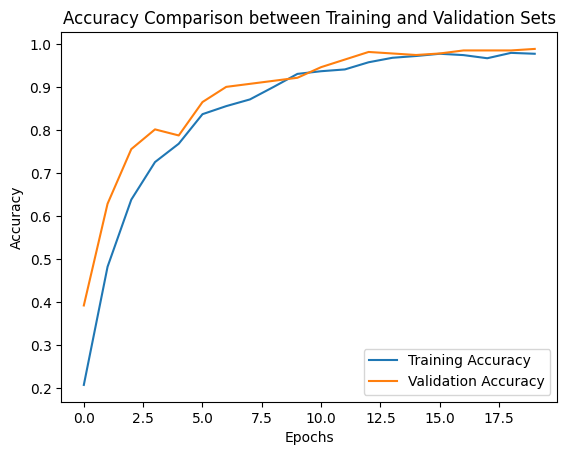

In [13]:
import matplotlib.pyplot as plt

#Plot Accuracy

plt.plot(vgg16.history['accuracy'])
plt.plot(vgg16.history['val_accuracy'])
plt.title("Accuracy Comparison between Training and Validation Sets")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

9/9 [==============================] - 1s 129ms/step


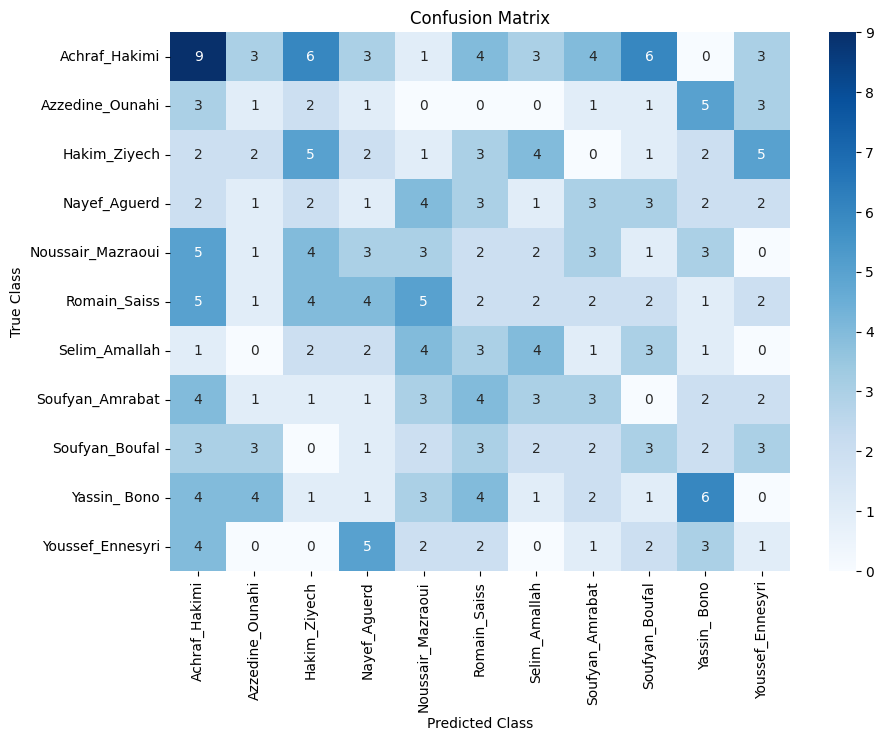

1/1 [==============================] - 0s 145ms/step


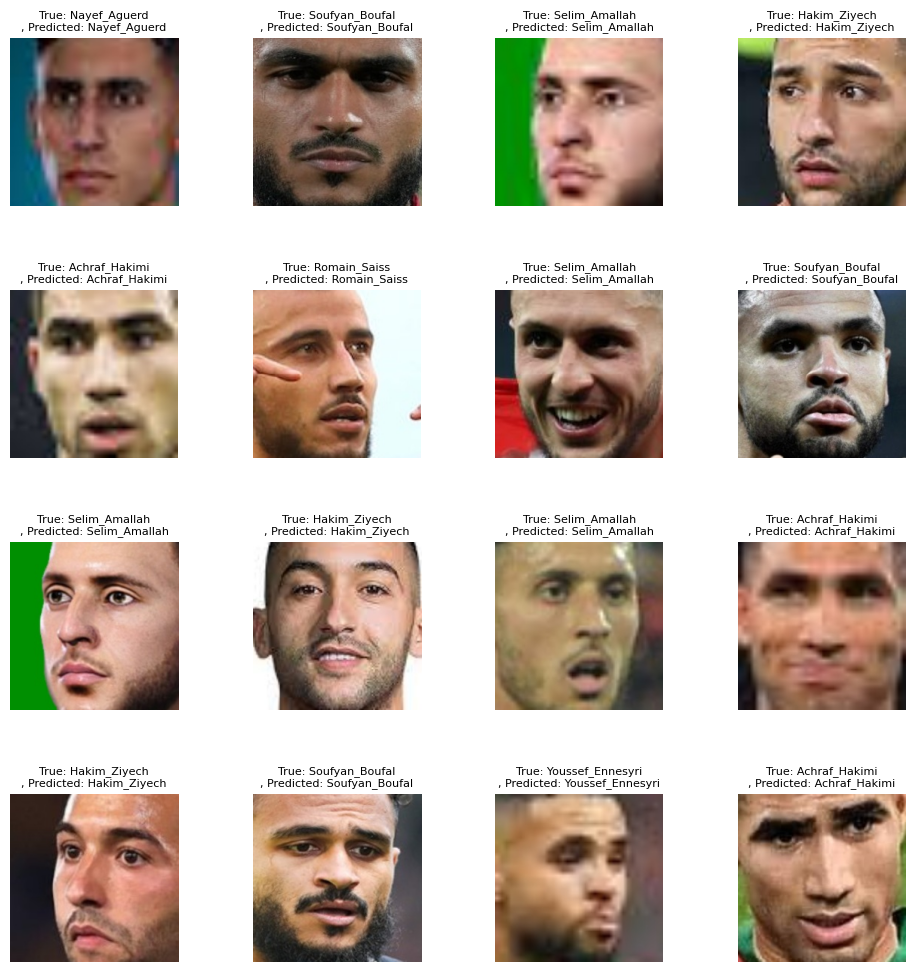

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Prédire les classes pour l'ensemble de test
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = test_generator.classes

# Créer la matrice de confusion
cm = confusion_matrix(true_classes, y_pred_classes)

# Afficher la matrice de confusion sous forme de graphique
class_labels = list(test_generator.class_indices.keys())
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Afficher quelques images de test avec leurs étiquettes prédites et réelles
sample_images, sample_labels = next(test_generator)

predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i in range(len(axes)):
    true_label = class_labels[np.argmax(sample_labels[i])]
    predicted_label = class_labels[predicted_classes[i]]
    axes[i].imshow(sample_images[i])
    axes[i].set_title(f"True: {true_label}\n, Predicted: {predicted_label}", fontsize=8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()

# Création d'un modéle VGG19 pour la classification binaire
Dans cette partie nous allons créer un modéle VGG19 pour la classification binaire.
Nous allons utiliser la base de données un deuxiéme Dataset qui contient deux classes:
 - les images de stars de l'équipe du Maroc
 - les images de contenant des faux visages.
 Ensuite nous allons tester notre modéle sur des images de stars de l'équipe du Maroc et des images de faux visages.


In [30]:
# Création du modèle VGG19
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Model
import numpy as np

# Redimensionner les images à 224 x 224 pixels
image_size = (224, 224)


# Chargement du modèle VGG19 pré-entraîné sans les couches supérieures (entièrement connectées)

base_model = VGG19(input_shape=image_size+(3,), include_top=False, weights="imagenet")

# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches au modèle
final_arc=Model(inputs=base_model.input,outputs=Dense(1,activation="sigmoid")(Flatten()(base_model.output)))

# Créer le modèle final
final_arc.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])



# Définir les chemins d'accès aux ensembles d'entraînement et de test du jeu de données des célébrités
train_path = '/content/drive/MyDrive/dataset/TeamOrNot/train'
test_path = '/content/drive/MyDrive/dataset/TeamOrNot/test'

# Configurer les générateurs de données pour l'entraînement et les tests
train_augmen=ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.3,horizontal_flip=True)
test_augmen=ImageDataGenerator(rescale=1./255)
final_train=train_augmen.flow_from_directory(train_path,target_size=(227,227),batch_size=35,class_mode='binary')
final_test=test_augmen.flow_from_directory(test_path,target_size=(227,227),batch_size=25,class_mode='binary')

# Affichage du Model
final_arc.summary()

Found 4552 images belonging to 2 classes.
Found 1364 images belonging to 2 classes.
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                         

In [31]:
start_time = time.time()

# Train the model
vgg19_binaire = final_arc.fit_generator(final_train,epochs=20,steps_per_epoch=20,validation_data=final_test)

end_time = time.time()

# Calculate the time it took to train the model
training_time = end_time - start_time
training_time_minutes = round(training_time / 60, 2)
print(f"Temps d'entraînement : {training_time_minutes} minutes")

<ipython-input-31-bf15f85acacd>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg19_binaire = final_arc.fit_generator(final_train,epochs=20,steps_per_epoch=20,validation_data=final_test)


Epoch 1/20
20/20 [==============================] - 800s 41s/step - loss: 0.2996 - accuracy: 0.9357 - val_loss: 0.0600 - val_accuracy: 0.9707
Epoch 2/20
20/20 [==============================] - 220s 11s/step - loss: 0.0311 - accuracy: 0.9910 - val_loss: 0.0240 - val_accuracy: 0.9949
Epoch 3/20
20/20 [==============================] - 194s 10s/step - loss: 0.0153 - accuracy: 0.9986 - val_loss: 0.0194 - val_accuracy: 0.9963
Epoch 4/20
20/20 [==============================] - 171s 9s/step - loss: 0.0308 - accuracy: 0.9900 - val_loss: 0.0258 - val_accuracy: 0.9919
Epoch 5/20
20/20 [==============================] - 146s 7s/step - loss: 0.0149 - accuracy: 0.9970 - val_loss: 0.0135 - val_accuracy: 0.9985
Epoch 6/20
20/20 [==============================] - 126s 6s/step - loss: 0.0305 - accuracy: 0.9886 - val_loss: 0.0147 - val_accuracy: 0.9956
Epoch 7/20
20/20 [==============================] - 101s 5s/step - loss: 0.0104 - accuracy: 0.9986 - val_loss: 0.0097 - val_accuracy: 0.9985
Epoch 8/20

In [32]:
# Sauvegarder le modèle pour une utilisation ultérieure
final_arc.save('/content/drive/MyDrive/model/VGG19Binary_TeamMaroc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


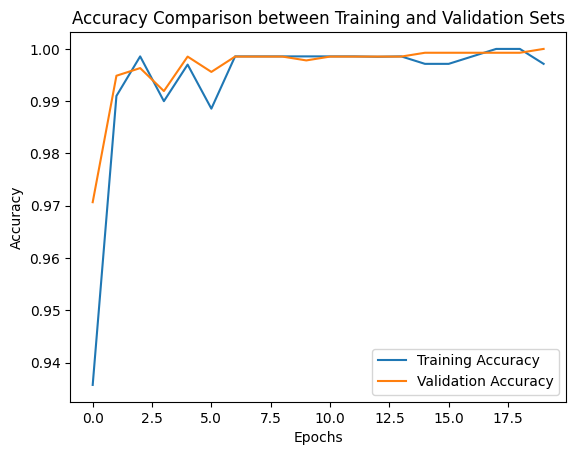

In [33]:
import matplotlib.pyplot as plt

#Plot Accuracy

plt.plot(vgg19_binaire.history['accuracy'])
plt.plot(vgg19_binaire.history['val_accuracy'])
plt.title("Accuracy Comparison between Training and Validation Sets")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

43/43 [==============================] - 12s 272ms/step


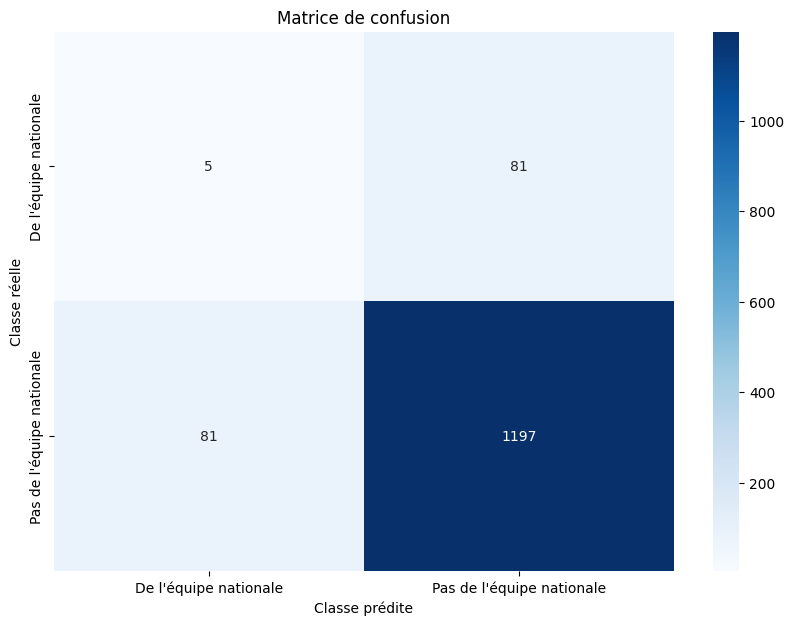

1/1 [==============================] - 0s 152ms/step


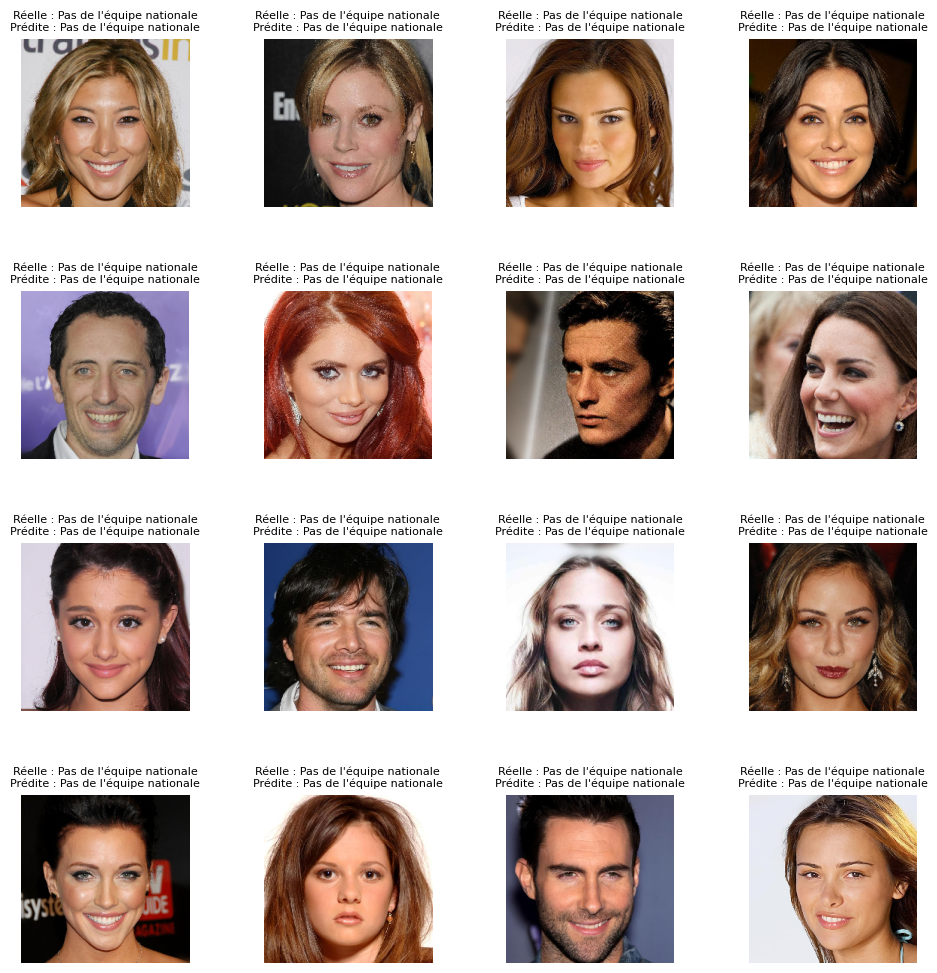

In [36]:
# Make predictions on the test data
y_pred = final_arc.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)  # Convert probabilities to class labels
true_classes = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, y_pred_classes)

# Display the confusion matrix
class_labels = ['De l\'équipe nationale', 'Pas de l\'équipe nationale']
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matrice de confusion')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.show()

# Display a sample of images with their predicted and true labels
sample_images, sample_labels = next(test_generator)

predictions = final_arc.predict(sample_images)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to class labels

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i in range(len(axes)):
    true_label = class_labels[int(sample_labels[i])]
    predicted_label = class_labels[predicted_classes[i]]
    axes[i].imshow(sample_images[i])
    axes[i].set_title(f"Réelle : {true_label}\nPrédite : {predicted_label}", fontsize=8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()

In [76]:
class_labels = ['De l\'équipe nationale', 'Pas de l\'équipe nationale']

def preprocess_image(image):
    image_size = (224, 224)
    image = load_img(image_path, target_size=image_size)
    image_array = np.expand_dims(img_to_array(image) / 255, axis=0)
    return image_array

def get_predicted_classes(model, images):
    predictions = model.predict(images)
    predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
    return predicted_classes

# Passer une image à notre modéle pour la prédiction
image_path = '/content/drive/MyDrive/dataset/Team_Maroc/test/Hakim_Ziyech/76.jpg'
preprocessed_image = preprocess_image(image_path)
predicted_class = get_predicted_classes(final_arc, preprocessed_image)
predicted_label = class_labels[predicted_class.item()]
# Affichage si c'est un joueur de l'équipe nationale ou pas
print('Prédiction:', predicted_label)


1/1 [==============================] - 0s 18ms/step
Prédiction: De l'équipe nationale


In [77]:
image_path = '/content/drive/MyDrive/dataset/TeamOrNot/train/1/208.jpg'
preprocessed_image = preprocess_image(image_path)
predicted_class = get_predicted_classes(final_arc, preprocessed_image)
predicted_label = class_labels[predicted_class.item()]
# Affichage si c'est un joueur de l'équipe nationale ou pas
print('Prédiction:', predicted_label)


1/1 [==============================] - 0s 94ms/step
Prédiction: Pas de l'équipe nationale


In [78]:
image_path = '/content/drive/MyDrive/dataset/TeamOrNot/train/0/1_1.jpg'
preprocessed_image = preprocess_image(image_path)
predicted_class = get_predicted_classes(final_arc, preprocessed_image)
predicted_label = class_labels[predicted_class.item()]
# Affichage si c'est un joueur de l'équipe nationale ou pas
print('Prédiction:', predicted_label)


1/1 [==============================] - 0s 22ms/step
Prédiction: De l'équipe nationale
